In [33]:
import numpy as np
from scipy import *
from pylab import *
import os

%matplotlib inline

In [34]:
folder_Pk = '/global/cscratch1/sd/jialiu/CAMELS/Pk/'
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

In [44]:
### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

#### Omega_m sigma_8 A1 A2 A3 A4
lhc_TNG = np.loadtxt(home+'latin_hypercube_params_IllustrisTNG.txt')
lhc_SIMBA = np.loadtxt(home+'latin_hypercube_params_SIMBA.txt')

########### should use log of A1-4 for GP
lhc_TNG = concatenate([lhc_TNG[:,:2], log10(lhc_TNG[:,2:])],axis=1)
lhc_SIMBA = concatenate([lhc_TNG[:,:2], log10(lhc_TNG[:,2:])],axis=1)

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [36]:
###################################################################
############ organize the files and save to the ideal format
###################################################################
# for ifolder in ['IllustrisTNG',  'IllustrisTNG_DM',  'SIMBA',  'SIMBA_DM']:
#     for iz in [0.00, 1.05, 2.00]:       
#         print (ifolder, iz)
#         Pk_arr = array([np.loadtxt(folder_Pk+'%s/LH_%i/Pk_m_z=%.2f.txt'%(ifolder, i, iz)) for i in range(1000)])
#         save(folder_Pk+'%s_Pk_m_z=%.2f.npy'%(ifolder, iz), Pk_arr[:,:,1])
#         if ifolder=='IllustrisTNG' and iz==0:
#             k=Pk_arr[0,:,0]
#             save(home+'%s_k_m_z=%.2f.npy'%(ifolder, iz), Pk_arr[0,:,0])
#         elif sum(Pk_arr[0,:,0]-k):
#             print (ifolder, iz, 'k different')
#             save(home+'%s_k_m_z=%.2f.npy'%(ifolder, iz), Pk_arr[0,:,0])

## First, take a look at the power spectra

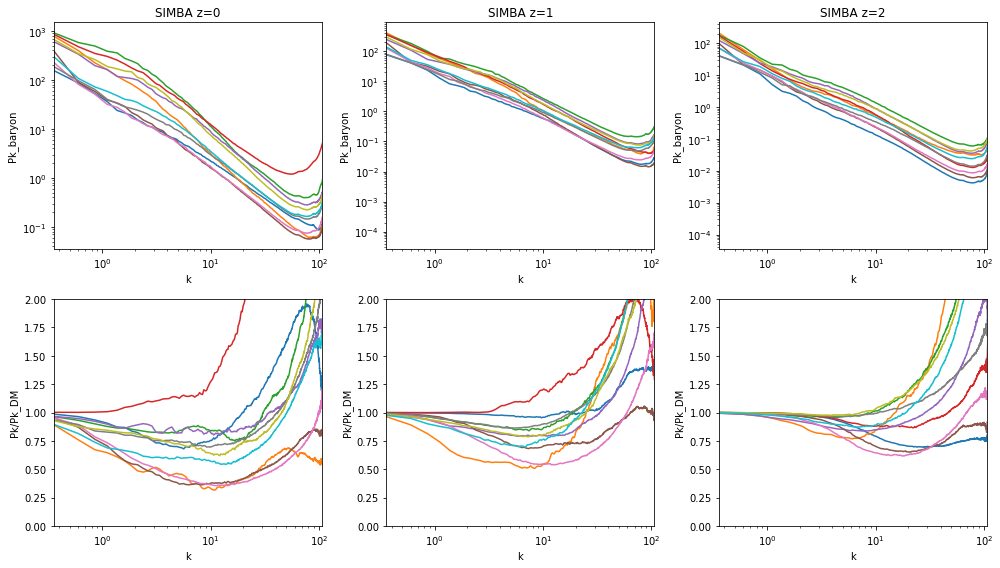

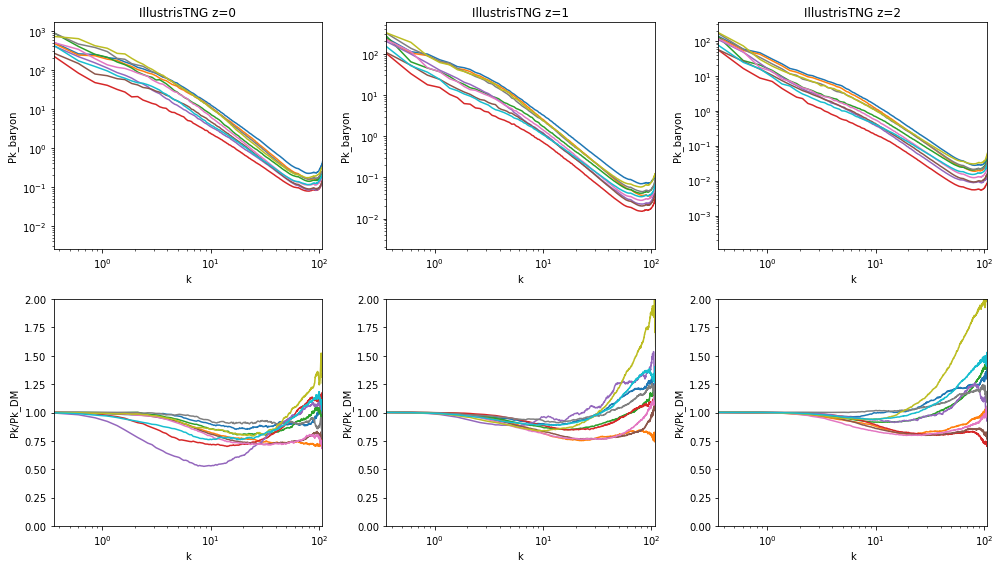

In [37]:
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')
# k=np.load(home+'Pk/%s_k_m_z=0.00.npy'%(ifolder))

# ifolder = 'SIMBA' # 'IllustrisTNG' #

for ifolder in ('SIMBA', 'IllustrisTNG'):
    Pk_0 = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(ifolder))
    Pk_DM_0 = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(ifolder))
    Pk_1 = np.load(home+'Pk/%s_Pk_m_z=1.05.npy'%(ifolder))
    Pk_DM_1 = np.load(home+'Pk/%s_DM_Pk_m_z=1.05.npy'%(ifolder))
    Pk_2 = np.load(home+'Pk/%s_Pk_m_z=2.00.npy'%(ifolder))
    Pk_DM_2 = np.load(home+'Pk/%s_DM_Pk_m_z=2.00.npy'%(ifolder))

    f, axes=subplots(2,3, figsize=(14,8))
    ax=axes[0]
    for i in range(10):
        ax[0].plot(k, Pk_0[i])
        ax[1].plot(k, Pk_1[i])
        ax[2].plot(k, Pk_2[i])

    for j in range(3):
        # ax[j].set_ylim(0, 2)
        ax[j].set_xlim(k[0], k[-20])
        ax[j].set_xscale('log')
        ax[j].set_yscale('log')
        ax[j].set_xlabel('k')
        ax[j].set_ylabel('Pk_baryon')
        ax[j].set_title('%s z=%i'%(ifolder,j))

    ax=axes[1]
    for i in range(10):
        ax[0].plot(k, Pk_0[i]/Pk_DM_0[i])
        ax[1].plot(k, Pk_1[i]/Pk_DM_1[i])
        ax[2].plot(k, Pk_2[i]/Pk_DM_2[i])

    for j in range(3):
        ax[j].set_ylim(0, 2)
        ax[j].set_xlim(k[0], k[-20])
        ax[j].set_xscale('log')
        ax[j].set_xlabel('k')
        ax[j].set_ylabel('Pk/Pk_DM')
        # ax[j].set_title('%s z=%i'%(ifolder,j))
    plt.tight_layout()
    show()

## Second, take a look at the parameter space (LHC)

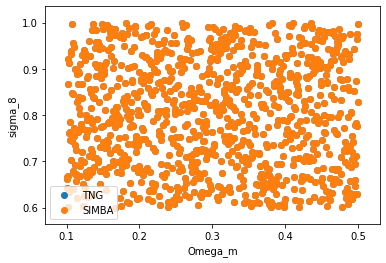

In [38]:
## sort(lhc_TNG.T[0])-sort(lhc_SIMBA.T[0])
### Jia: the 2 parameter files are not sorted the same, but seem to have the same parameters 
### Paco: this is due to LHC, they're not supposed to be the same
scatter(lhc_TNG.T[0], lhc_TNG.T[1], label='TNG')
scatter(lhc_SIMBA.T[0], lhc_SIMBA.T[1], label='SIMBA')
xlabel('Omega_m'); ylabel('sigma_8')
legend()
show()

In [39]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

## Step 3, build a Gaussian Process for Pk
## need to find best kernel, noise, kmin

In [40]:
########## test gaussian process by take one out, do this for a few random realizations
#### pick a cosmology close-ish to the center
########## remove one and test
# lhc_test=np.delete(lhc_TNG, idx_min,axis=0)
# Pk_test = np.delete(Pk_0, idx_min,axis=0)
# Pk_DM_test = np.delete(Pk_DM_0, idx_min,axis=0)
# test_distance=(lhc_TNG/mean(lhc_TNG, axis=0)-1)**2
# idx_min = int(where(test_distance==amin(test_distance))[0])
# print (idx_min, lhc_TNG[idx_min])
# print (mean(lhc_TNG, axis=0))

In [46]:
### use the std from all 1000 Pk for now, it is over estimation, should use theory later... e.g. counting modes
## https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

kmax=10
noise_std =  0.05

kidx=len(k[k<kmax])## cut at kmax
knew = k[:kidx]
r_Pk0=(Pk_0/Pk_DM_0)

########## remove 100 and use 900 to build, test on 100
lhc_test=lhc_TNG[:900]
r_Pk = r_Pk0[:900, :kidx]

rtrue= r_Pk0[900:, :kidx]
lhc_true=lhc_TNG[900:]

print (noise_std, knew.shape)
print (lhc_test.shape, r_Pk.shape)
print (lhc_true.shape, rtrue.shape)


0.05 (39,)
(900, 6) (900, 39)
(100, 6) (100, 39)


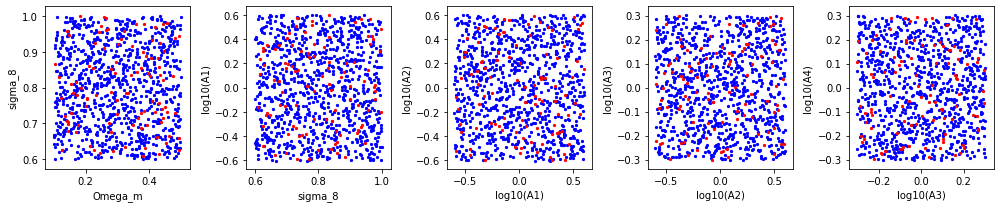

In [45]:
#  
labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    ax[i].scatter(lhc_test.T[i], lhc_test.T[i+1], color='b', label='900',s=5)
    ax[i].scatter(lhc_true.T[i], lhc_true.T[i+1], color='r', label='100',s=5)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1])    
plt.tight_layout()
show()

In [47]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=noise_std**2)

###### takes long to compute
gaussian_process.fit(lhc_test, r_Pk)

GaussianProcessRegressor(alpha=0.0025000000000000005,
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

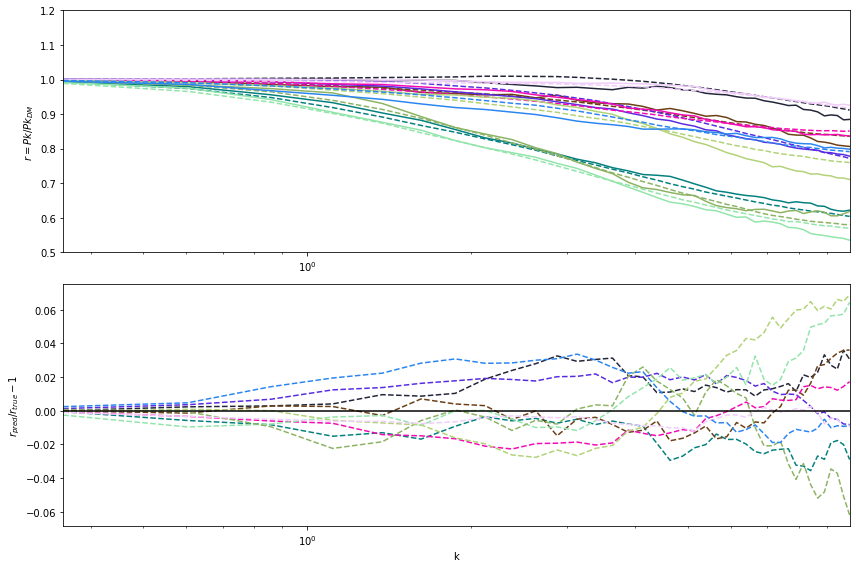

In [57]:
########### may have to build each bin individually
seed(9)

f, ax=subplots(2,1, figsize=(12,8))

for i in range(10):
    
    test_pred = (gaussian_process.predict(lhc_true[i].reshape(-1,1).T)).flatten()
    test_true = rtrue[i].flatten()
    icolor=rand(3)
    ax[0].plot(knew, test_pred, '--',color=icolor)
    ax[0].plot(knew, test_true, '-',color=icolor, label='%s'%(lhc_true[i]))
    ax[1].plot(knew, test_pred/test_true-1, '--',color=icolor)
    

ax[0].set_ylim(0.5, 1.2)
ax[0].set_xlim(knew[0], knew[-1])
ax[0].set_xscale('log')
ax[0].set_ylabel('$r=Pk/Pk_{DM}$')
# ax[0].legend()

ax[1].set_xlim(knew[0], knew[-1])
ax[1].set_ylabel('$r_{pred}/r_{true}-1$')
ax[1].plot(knew, zeros(len(knew)),'k-')
ax[1].set_xscale('log')
ax[1].set_xlabel('k')

plt.tight_layout()
show()